<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/GCP_AMPL_FNL_Workshop_06052021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Protein Target-focussed Binding Data Curation, Exploratory Data Analysis and Featurization using AMPL** </center>
(Note this notebook needs pre-installed AMPL, hence, will not run on COLAB without AMPL installation. COLAB compatible version of this notebook is available from here, https://github.com/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/AMPL_FNL_Workshop_06052021.ipynb)


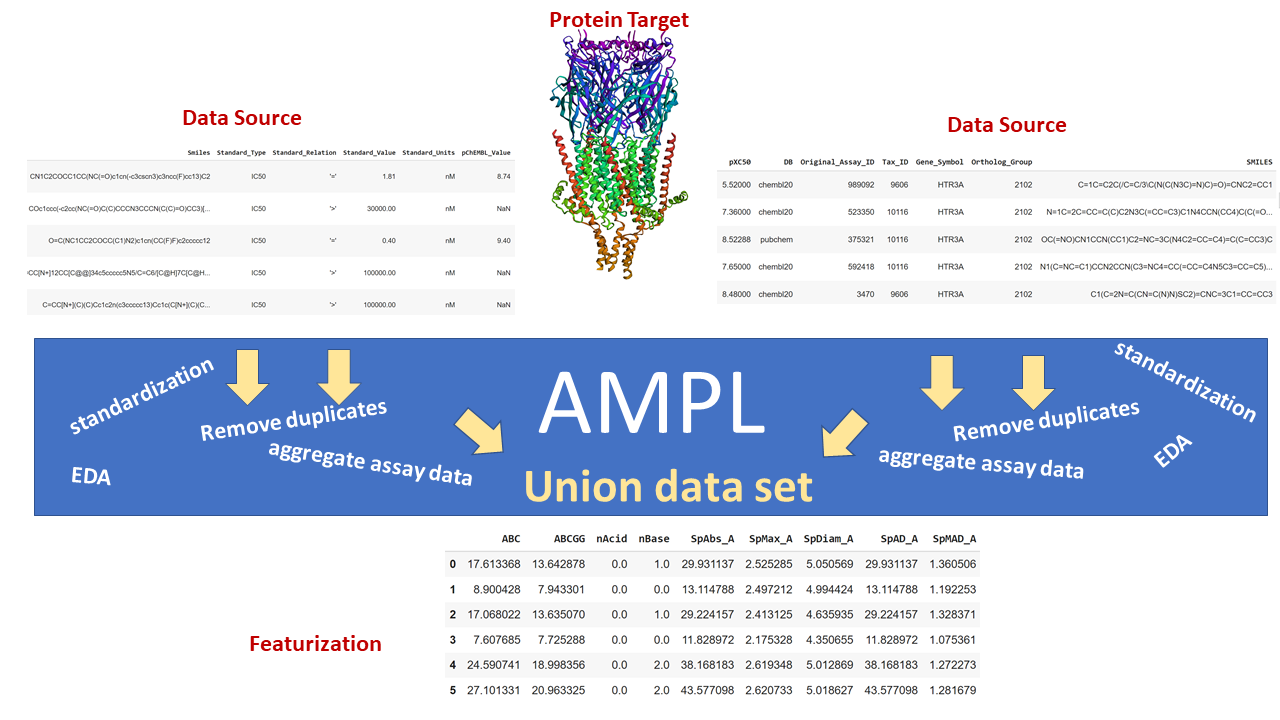

In [1]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/Img/workshop1-banner.png", width=1000)

***In this AMPL notebook, we provide some of Exploratory Data Analysis (EDA) steps that are relevant for drug discovery.***

In this notebook we will analyze molecular data and assay measurement datasets collected from ChEMBL and Excape-DB.
1. To make changes to the notebook, ***COPY*** the notebook into your system 
2. For this tutorial, we will use HTR3A target (https://www.ncbi.nlm.nih.gov/gene/3359) binding data from two different data sources, ExCAPE-DB and ChEMBL. *If you want to use your own target related data, you can download it from the following databases*:
  - https://www.ebi.ac.uk/chembl/
  - https://solr.ideaconsult.net/search/excape/


If you have any AMPL-code related questions, please ask them via AMPL issues page, https://github.com/ATOMScience-org/AMPL/issues


# **Scope of the tutorial:**



1.   Load target-focussed binding datasets
  * For demonstration, we have chosen only two sources (ChEMBL and ExCAPE-DB). One could add additional datasources like Drug Target Commons, DTC. 
2.   Clean, preprocess and examine the data
3.   Merge the datasets (if you have multiple data sources)
4.   Carry out EDA
  - Examine compound diversity
  - Create curated data 
  - filter to eliminate extreme value data
5.  Add features
6.  Store the ML ready data for modeling

**Please note that this notebook provides some ideas on how to collect, merge and curate datasets. There are many other ways of accomplishing the same and it depends on the dataset(s) sources. AMPL will help you accomplish these steps reliably and with less coding.**

## **Google Cloud Platform Environment** 


* Serverless environment for Jupyter notebook
* It is a VM on the cloud running Ubuntu 
* CPU/GPU options

## **AMPL Tutorial Links** 


More elaborate tutorial on this and other topics are available from the following AMPL links,  
* https://github.com/ATOMScience-org/AMPL/tree/Tutorials/atomsci/ddm/examples/tutorials
* https://github.com/ravichas/AMPL-Tutorial

#**AMPL Installation and load relevant libraries**

In [ ]:
!date

Thu Jun 10 14:56:01 UTC 2021


## **Uncomment/run the following code chunk to install the packages. After installation, please comment them to prevent from getting reinstalled again**

In [ ]:
# ! pip install py3Dmol
# ! pip install mordred
# ! pip install matplotlib-venn

In [ ]:
import deepchem as dc
import py3Dmol

## **Load AMPL/relevant Libraries**

In [ ]:
# Temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import importlib as iml
from mordred import Calculator
from matplotlib_venn import venn3
from matplotlib_venn import venn2

import deepchem as dc

# set up sns visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

In [ ]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd

from atomsci.ddm.pipeline import featurization as feat

# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# **HTR3A Protein Basic Biology**




*   Hydroxytrptamine receptor 3A (HTR3A)
*   HTR3A gene also encodes a protein also called HTR3A 
*   HTR3A belongs to ligand-gated ion channel receptor subfamily. It is a receptor for 5-hydroxytryptamine (serotonin) 
  * Serotonin: a harmone, functions as a neurtransmitter 
*   Receptor as homopentamer or combining with other subtypes to form the biologicaly active heteropentameric form to become biologically active


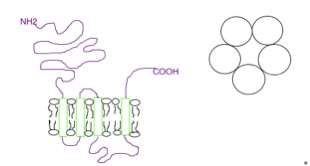

In [ ]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/8/84/Ionophore_receptor.jpg",
      width=500)

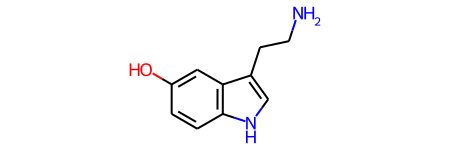

In [ ]:
# Serotonin
from IPython.core.display import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")
Chem.rdDepictor.SetPreferCoordGen(True)
Chem.rdDepictor.Compute2DCoords(mol)

mol

In [ ]:
import py3Dmol 
view=py3Dmol.view(query='pdb:6y5a')
view.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

**Why HTR3A?**

* Therapeutic target for cancer therapies  
* HTR3A approved FDA drug target
* Variants associated with psychiatric disorders such as biploar disorders/depression

# **Data Sources and Ingestion** 

ChEMBL (https://www.ebi.ac.uk/chembl/) contains all the PubChem (https://pubchem.ncbi.nlm.nih.gov/) data. ExCAPE-DB (https://solr.ideaconsult.net/search/excape/) and Drug Target Commons (DTC; https://drugtargetcommons.fimm.fi) contains curated data and also include mutation data. For this demonstration, we have used only ChEMBL and Excape-DB.


## **Data Ingestion**

Data file `HTR3A_Excape.csv` and `HTR3A_chEMBL.csv` were downloaded from ChEMBL and ExCAPE-DB websites. The data contains only human HTR3A target related data. 

In [ ]:
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/A-HTR3A/HTR3A_Excape.csv >& /dev/null
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/A-HTR3A/HTR3A_ChEMBL.csv >& /dev/null

In [ ]:
excape = pd.read_csv("HTR3A_Excape.csv", sep=',', header=0)
chembl = pd.read_csv("HTR3A_ChEMBL.csv", sep=',', header=0 )

excape_orig = excape.copy(deep=True)
chembl_orig = chembl.copy(deep=True)

In [ ]:
# excape.iloc[1:3,]

In [ ]:
# chembl.iloc[1:3, ]

# **Questions for the data exploration phase of the project**
 


Here is a list of possible questions during exploration:
- Number of data points in each DB?
- Molecular identifier types from each DB? 
  - For example, #HBD is it an integer or a string variable? 
- Outcome variable (types, units) from each DB? 
- Modeling works well in log-transformed data, pIC50 (IC50 -> pIC50)?
  - pIC50 = -log(IC50)
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- How we might combine these data sources together?

In [ ]:
print(chembl.shape)
print(excape.shape)

(1950, 45)
(649, 11)


## **Examine and clean data** 

### Questions to ask while exploring data
*   Are there any spaces in the column names? 
  - For example, `'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction'`
*  Upper-case to lower-case names? 
*  If the column contains 'None'. Can we change it to NaN? 
  - There are some advantages in having NaN than None. Google search using `None vs NaN in python` for several interesting discussions 
*  Does the data need tidying?
*  Does the DB need SMILES column consistent naming. 
  - This will come handy when we merge datasets
*  Renaming column name to have consistent naming?  

In [ ]:
chembl.head(3)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3233676,NaN,0,622.85,2,6.84,22a,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,Inhibition,'=',13.75,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3240658,Reversible inhibition of human 5-HT3A expresse...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3232706,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,None,NaN
1,CHEMBL773,GLYCINE,4,75.07,0,-0.97,glycine,NCC(=O)O,EC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN
2,CHEMBL3261486,NaN,0,312.37,0,0.88,9,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,Activity,'=',83.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3268498,Partial agonist activity at human 5-HT3A recep...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3259590,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN


In [ ]:
# first let us get rid of spaces
chembl.columns = chembl.columns.str.replace(' ','_') 
excape.columns = excape.columns.str.replace(' ','_') 

<font color="green">**You can add other cleaning or tidying steps here**</font>

# **ChEMBL Dataset Curation**

ChEMBL bioassay publication: https://academic.oup.com/nar/article/47/D1/D930/5162468

**Number of compounds?**

In [ ]:
chembl.shape

(1950, 45)

In [ ]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3233676,NaN,0,622.85,2,6.84,22a,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,Inhibition,'=',13.75,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3240658,Reversible inhibition of human 5-HT3A expresse...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3232706,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,None,NaN
1,CHEMBL773,GLYCINE,4,75.07,0,-0.97,glycine,NCC(=O)O,EC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN
2,CHEMBL3261486,NaN,0,312.37,0,0.88,9,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,Activity,'=',83.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3268498,Partial agonist activity at human 5-HT3A recep...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3259590,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN
3,CHEMBL3943065,NaN,0,401.47,0,2.21,BDBM221658,CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2,IC50,'=',1.81,nM,8.74,NaN,388070,UO_0000065,21.78,0.43,6.53,12.1,False,CHEMBL3888296,In Vitro Inhibition of Ca Flux Assay: The 5HT3...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK-293T,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3886642,37,BindingDB Database,NaN,2016.0,CHEMBL3706569,NaN
4,CHEMBL2086584,NaN,0,427.55,0,2.99,27,COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...,IC50,'>',30000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL2091623,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL2086339,1,Scientific Literature,J. Med. Chem.,2012.0,CHEMBL3307715,NaN


## **Chembl Standard Units:**

According to Chembl, *The published units are taken directly from the literature and we then attempt to standardise these to report as a **standard type**. This is an ongoing curation task, which was started with the most common units first.*

In [ ]:
pd.DataFrame(chembl.Standard_Type.value_counts()).T

,Ki,IC50,Inhibition,Activity,Ka,EC50,Vmax,Kd,% Inhibition of Control Specific Binding (Mean n=2),% Ctrl,pKi,Efficacy,pIC50,Emax,Kb,Selectivity ratio
Standard_Type,611,558,478,138,46,41,25,22,8,8,4,4,3,2,1,1


<AxesSubplot:>

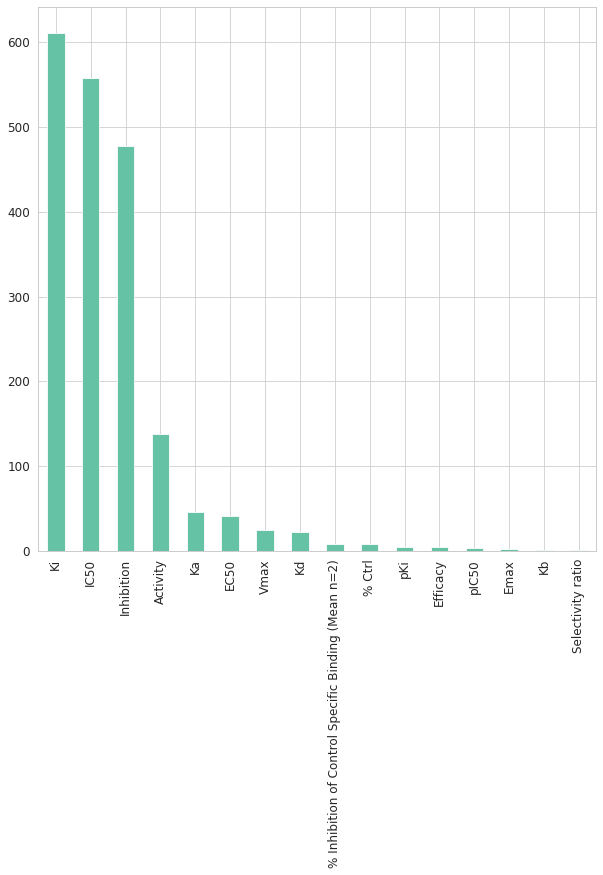

In [ ]:
chembl.Standard_Type.value_counts().plot(kind='bar')

In [ ]:
chembl.Assay_Description

0       Reversible inhibition of human 5-HT3A expresse...
1       Antagonist activity at human 5HT3A receptor ex...
2       Partial agonist activity at human 5-HT3A recep...
3       In Vitro Inhibition of Ca Flux Assay: The 5HT3...
4       Antagonist activity at human 5HT3A receptor ex...
                              ...                        
1945                  GPCRScan assay: inhibition of 5-HT3
1946                  GPCRScan assay: inhibition of 5-HT3
1947                  GPCRScan assay: inhibition of 5-HT3
1948    Antagonist activity at human 5-HT3A receptor e...
1949    Displacement of [3H]-GR65630 from human 5-HT3 ...
Name: Assay_Description, Length: 1950, dtype: object

In [ ]:
chembl.Standard_Units.unique()

array(['%', nan, 'nM', 'uM'], dtype=object)

In [ ]:
chembl[chembl.Standard_Type == "IC50"].head(5)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
3,CHEMBL3943065,NaN,0,401.47,0,2.21,BDBM221658,CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2,IC50,'=',1.81,nM,8.74,NaN,388070,UO_0000065,21.78,0.43,6.53,12.1,False,CHEMBL3888296,In Vitro Inhibition of Ca Flux Assay: The 5HT3...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK-293T,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3886642,37,BindingDB Database,NaN,2016.0,CHEMBL3706569,NaN
4,CHEMBL2086584,NaN,0,427.55,0,2.99,27,COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...,IC50,'>',30000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL2091623,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL2086339,1,Scientific Literature,J. Med. Chem.,2012.0,CHEMBL3307715,NaN
5,CHEMBL3982898,NaN,0,349.38,0,2.16,BDBM221679,O=C(NC1CC2COCC(C1)N2)c1cn(CC(F)F)c2ccccc12,IC50,'=',0.40,nM,9.40,NaN,388138,UO_0000065,26.90,0.51,7.24,17,False,CHEMBL3888296,In Vitro Inhibition of Ca Flux Assay: The 5HT3...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK-293T,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3886642,37,BindingDB Database,NaN,2016.0,CHEMBL3706569,NaN
6,CHEMBL1180293,ALCURONIUM,0,666.91,2,5.48,23,C=CC[N+]12CC[C@@]34c5ccccc5N5/C=C6/[C@H]7C[C@H...,IC50,'>',100000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN
7,CHEMBL206666,NaN,0,614.47,1,5.53,20,C=CC[N+](C)(C)Cc1c2n(c3ccccc13)Cc1c(C[N+](C)(C...,IC50,'>',100000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN


## **ChEMBL Dataset Pre-curation** 

Databases contain data collected from data collected from multiple sources.

The questions that we can ask during this step: 
*   Are there duplicates? If so, how variable the relevant assay measurements are
First let us change units to be the same for all responses

In [ ]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

In [ ]:
# chembl.columns
# rcols = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'Standard_Value_nM']
# chembl[chembl['Standard_Units'] =='uM'][rcols]

## ChEMBL EDA


## Exploring BioAssay data 

* The BioAssay Ontology (BAO) link, https://www.ebi.ac.uk/ols/ontologies/bao
* BAO publication, https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-257
* Assay Type (gleaned from ChEMBL): 
  - Binding (B) - Data measuring binding of compound to a molecular target, e.g. Ki, IC50, Kd.
  - Functional (F) - Data measuring the biological effect of a compound, e.g. %cell death in a cell line, rat weight.

In [ ]:
#tdf: temp df
tdf = chembl[chembl['Molecule_ChEMBL_ID'] == 'CHEMBL2107804']
tdf = tdf[chembl['Standard_Type'] == 'IC50']
cols = ['Molecule_Name', 'Smiles', 'pChEMBL_Value', 'Assay_Type', 'Assay_Organism', 'BAO_Label', 'BAO_Format_ID']
tdf = tdf.reset_index()

In [ ]:
# chembl

<AxesSubplot:xlabel='index', ylabel='pChEMBL_Value'>

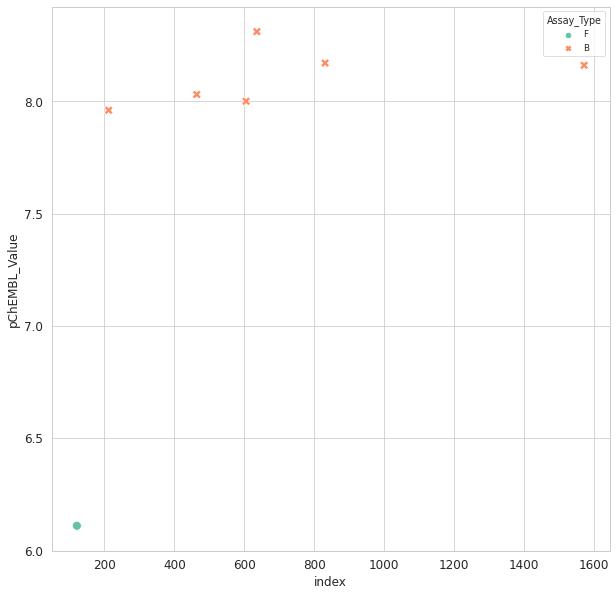

In [ ]:
sns.scatterplot(data=tdf, x = 'index', y = 'pChEMBL_Value', hue = 'Assay_Type', style="Assay_Type", s=80)

**Summarize, describe, plot data for analysis. Do you see all the data when you describe? What is missing and why?**

In [ ]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,1950.000000,1.784000e+03,975.000000,810.000000,1950.000000,1801.000000,1.784000e+03
mean,0.286667,6.279166e+04,7.277262,22.023802,9.757436,2012.493615,6.299437e+04
std,0.984944,2.367589e+06,1.601719,6.780721,17.537913,4.327058,2.367584e+06
min,0.000000,-1.889000e+01,4.000000,4.500000,1.000000,1990.000000,-1.889000e+01
25%,0.000000,3.000000e+00,5.990000,18.225000,1.000000,2010.000000,3.097500e+00
50%,0.000000,5.000000e+01,7.500000,23.025000,1.000000,2013.000000,5.000000e+01
75%,0.000000,7.910825e+02,8.700000,25.970000,1.000000,2016.000000,1.089650e+03
max,4.000000,1.000000e+08,10.500000,49.740000,54.000000,2020.000000,1.000000e+08



Why do some columns seem numeric but not give mean, SD? 
Examine chembl dataframe and may be it is something to do with the dtypes?

In [ ]:
# Let us display some of the columns that we know should be numeric
chembl[['Molecular_Weight','AlogP']].head(3)

,Molecular_Weight,AlogP
0,622.85,6.84
1,75.07,-0.97
2,312.37,0.88


In [ ]:
chembl=chembl.replace('None', np.nan)

**Make sure the column values are in appropriate data types**

In [ ]:
# Make sure after removing None types, recast the column as numeric
numeric_cols=['Molecule_Max_Phase', 'Molecular_Weight', '#RO5_Violations', 
              'AlogP', 'Standard_Value_nM','pChEMBL_Value', 
              'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE', 
              'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']

for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

What is ligand efficiency? 

(quote from **The role of ligand efficiency metrics in drug discovery**,  https://www.nature.com/articles/nrd4163/boxes/bx3)

*Ligand efficiency measures quantify the molecular properties, particularly size and lipophilicity, of small molecules that are required to gain binding affinity to a drug target. There are additional efficiency measures for groups in a molecule, and for combinations of size and lipophilicity.*


- **Ligand Efficiency (LE)**
- **Lipophilic ligand efficiency (LLE)** = p(Activity) and lipophilicity (cLogP or LogD)
- **binding efficiency index (BEI)** 
- **SEI** Refer to ChEMBL documentation

In [ ]:
# lot more columns than before
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Assay_Subcellular_Fraction,Source_ID,Document_Year,Standard_Value_nM
count,1950.000000,1949.000000,1941.000000,1941.000000,1.784000e+03,975.000000,810.000000,807.000000,807.000000,807.000000,0.0,1950.000000,1801.000000,1.784000e+03
mean,0.286667,387.760164,0.224111,3.162499,6.279166e+04,7.277262,22.023802,0.420867,4.651921,16.968451,NaN,9.757436,2012.493615,6.299437e+04
std,0.984944,141.507010,0.559598,1.507776,2.367589e+06,1.601719,6.780721,0.128024,2.224646,10.960766,NaN,17.537913,4.327058,2.367584e+06
min,0.000000,75.070000,0.000000,-2.230000,-1.889000e+01,4.000000,4.500000,0.080000,-4.390000,2.880000,NaN,1.000000,1990.000000,-1.889000e+01
25%,0.000000,309.330000,0.000000,2.140000,3.000000e+00,5.990000,18.225000,0.350000,3.545000,10.820000,NaN,1.000000,2010.000000,3.097500e+00
50%,0.000000,361.450000,0.000000,2.920000,5.000000e+01,7.500000,23.025000,0.440000,4.980000,14.430000,NaN,1.000000,2013.000000,5.000000e+01
75%,0.000000,426.470000,0.000000,3.860000,7.910825e+02,8.700000,25.970000,0.500000,6.385000,19.665000,NaN,1.000000,2016.000000,1.089650e+03
max,4.000000,1165.320000,3.000000,10.370000,1.000000e+08,10.500000,49.740000,0.950000,9.330000,106.270000,NaN,54.000000,2020.000000,1.000000e+08


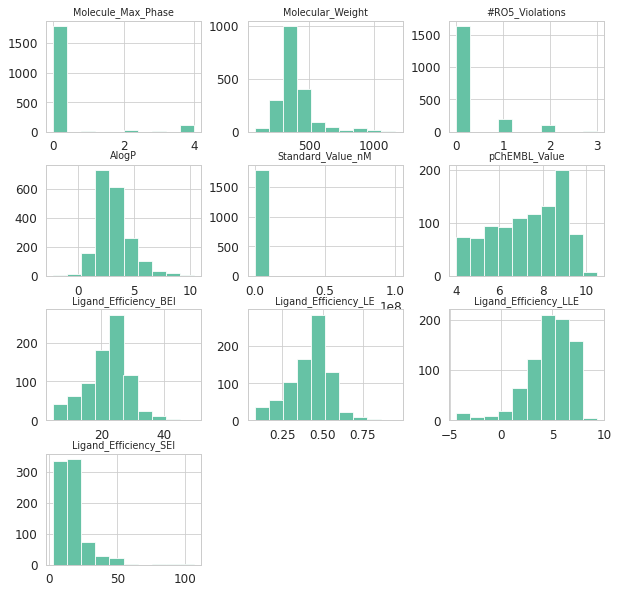

In [ ]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

## EDA plays an important role during harmonization?

In [ ]:
# temp df
tdf = chembl[chembl['Molecule_ChEMBL_ID'] == 'CHEMBL1189679']
tdf = tdf[tdf['Standard_Type'] == 'IC50']

In [ ]:
tdf[['Smiles','Standard_Type','Standard_Relation','Standard_Units','Standard_Value','pChEMBL_Value','Assay_Type']].head()

,Smiles,Standard_Type,Standard_Relation,Standard_Units,Standard_Value,pChEMBL_Value,Assay_Type
312,O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2,IC50,'=',nM,0.83,9.08,B
663,O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2,IC50,'=',nM,4.40,8.36,B
664,O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2,IC50,'=',nM,3.64,8.44,B
718,O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2,IC50,'=',nM,13.10,7.88,B
1128,O=C1c2cccc3c2[C@H](CCC3)CN1[C@@H]1CN2CCC1CC2,IC50,'=',nM,1.30,8.89,B


In [ ]:
tdf['pChEMBL_Value'].mean()

8.66875

In [ ]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')

In [ ]:
chembl_types[chembl_types.index == 'CHEMBL1189679']

Standard_Type,EC50,IC50,Kd,Ki
Molecule_ChEMBL_ID,,,,
CHEMBL1189679,NaN,8.66875,9.426,10.5


Standard_Type,EC50,IC50,Kd,Ki
count,19.000000,408.000000,4.000000,405.000000
mean,6.684474,7.357423,7.681750,7.178580
std,1.152117,1.676965,2.153942,1.435567
min,4.580000,4.000000,4.890000,4.000000
25%,6.120000,5.792500,6.532500,6.150000
50%,6.750000,7.755000,8.205500,7.285000
75%,7.210000,8.900000,9.354750,8.330000
max,8.960000,10.050000,9.426000,10.500000


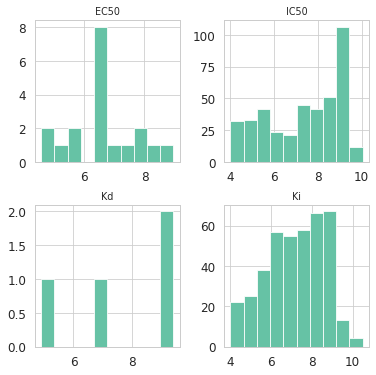

In [ ]:
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the distribution of IC50/ki?**

# **ExCAPE-DB Dataset Curation**
ExCAPE-DB publication: https://pubmed.ncbi.nlm.nih.gov/28316655/ 

In [ ]:
excape.shape

(649, 11)

In [ ]:
excape.head(3)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZGOVLGMSGAOMP-FZYUQVBKNA-N,CHEMBL404232,3359,A,5.52000,chembl20,989092,9606,HTR3A,2102,C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1
1,BAZZAIKMNMNZJS-PKRZOPRNNA-N,CHEMBL494999,79246,A,7.36000,chembl20,523350,10116,HTR3A,2102,N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...
2,ARXTZNGJWWBBMH-LQFNOIFHNA-N,44157937,79246,A,8.52288,pubchem,375321,10116,HTR3A,2102,OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C


In [ ]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES'],
      dtype='object')

In [ ]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

In [ ]:
# cutoff 10 uM
excape[excape['Activity_Flag'] == 'A']['pXC50'].describe()[['min','max']]

min     5.0
max    10.5
Name: pXC50, dtype: float64

In [ ]:
excape[excape['Activity_Flag'] == 'N']['pXC50'].describe()[['min','max']]

min    1.00
max    4.94
Name: pXC50, dtype: float64

In [ ]:
excape['DB'].unique()

array(['chembl20', 'pubchem'], dtype=object)

## **ExCAPE-DB Dataset Pre-curation**

In [ ]:
excape=excape.replace('None', np.nan)
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZGOVLGMSGAOMP-FZYUQVBKNA-N,CHEMBL404232,3359,A,5.52000,chembl20,989092,9606,HTR3A,2102,C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1
1,BAZZAIKMNMNZJS-PKRZOPRNNA-N,CHEMBL494999,79246,A,7.36000,chembl20,523350,10116,HTR3A,2102,N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...
2,ARXTZNGJWWBBMH-LQFNOIFHNA-N,44157937,79246,A,8.52288,pubchem,375321,10116,HTR3A,2102,OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C
3,ASQVLAWCAVGHRV-UHFFFAOYNA-N,CHEMBL576046,79246,A,7.65000,chembl20,592418,10116,HTR3A,2102,N1(C=NC=C1)CCN2CCN(C3=NC4=CC(=CC=C4N5C3=CC=C5)...
4,ATBPRFXCCZLQCU-KHCWMJRFNA-N,CHEMBL40260,3359,A,8.48000,chembl20,3470,9606,HTR3A,2102,C1(C=2N=C(CN=C(N)N)SC2)=CNC=3C1=CC=CC3


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,649.000000,645.000000,6.490000e+02,649.000000,649.0
mean,16215.274268,6.983770,6.633640e+05,9715.318952,2102.0
std,27698.741204,1.505524,2.569910e+05,207.728422,0.0
min,3359.000000,1.000000,3.123000e+03,9606.000000,2102.0
25%,3359.000000,5.800000,5.369680e+05,9606.000000,2102.0
50%,3359.000000,7.161150,6.525690e+05,9606.000000,2102.0
75%,3359.000000,8.140000,8.059070e+05,9606.000000,2102.0
max,79246.000000,10.500000,1.350972e+06,10116.000000,2102.0


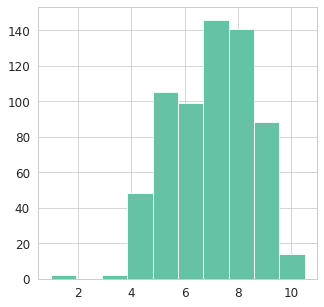

In [ ]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

# **What are the relevant input and the outputs for modeling?** 


**ChEMBL**
*   Input: SMILES
*   Output: IC50 or other units

**ExCAPE-DB**
* Input: SMILES
* Output: PXC50 or Activity_Flag



Things to watch out for: 
* What is the output (IC50, ki or PIC50)?
* How variable are you assay measurements?
* Assay details (gene id?) 
* How much you want to tolerate? 

# **Compare pResponse values across ChEMBL and Excape-DB**


- create a histogram or kde plot with legend showing distributions for all two datasets on the same plot

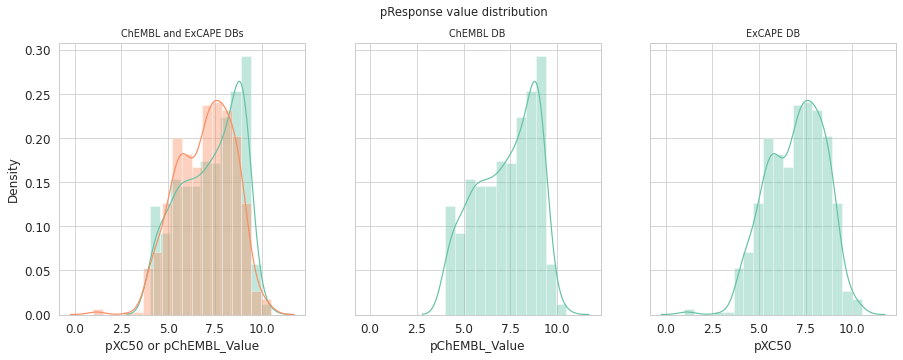

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('pResponse value distribution')

sns.distplot(chembl.pChEMBL_Value, ax=axes[0])
sns.distplot(excape.pXC50, ax=axes[0]);
axes[0].title.set_text('ChEMBL and ExCAPE DBs')
axes[0].set(xlabel="pXC50 or pChEMBL_Value")

sns.distplot(chembl.pChEMBL_Value, ax=axes[1])
axes[1].title.set_text('ChEMBL DB')

sns.distplot(excape.pXC50, ax=axes[2]);
axes[2].title.set_text('ExCAPE DB')

# **Analysis**


- What value types you would model and why?
- How would you use this data for a classification model?
  - Do any of the two datasets include a column you could use for classification?

<p> For this data, we could build models using either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed. According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult local expert), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity)

## AMPL EDA tips
- Make sure SMILES strings exist for each compounds
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

# **EDA: Examine compound overlaps**


Start with questions you have about the compounds at this point in time, such as:
- What compounds are in each set? do they overlap?
- Are the compounds diverse or similar to each other?

In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM
0,CHEMBL3233676,NaN,0.0,622.85,2.0,6.84,22a,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,Inhibition,'=',13.75,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3240658,Reversible inhibition of human 5-HT3A expresse...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3232706,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,NaN,NaN,13.75
1,CHEMBL773,GLYCINE,4.0,75.07,0.0,-0.97,glycine,NCC(=O)O,EC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN,NaN
2,CHEMBL3261486,NaN,0.0,312.37,0.0,0.88,9,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,Activity,'=',83.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3268498,Partial agonist activity at human 5-HT3A recep...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3259590,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN,83.00


In [ ]:
excape.head(3)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZGOVLGMSGAOMP-FZYUQVBKNA-N,CHEMBL404232,3359,A,5.52000,chembl20,989092,9606,HTR3A,2102,C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1
1,BAZZAIKMNMNZJS-PKRZOPRNNA-N,CHEMBL494999,79246,A,7.36000,chembl20,523350,10116,HTR3A,2102,N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...
2,ARXTZNGJWWBBMH-LQFNOIFHNA-N,44157937,79246,A,8.52288,pubchem,375321,10116,HTR3A,2102,OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C


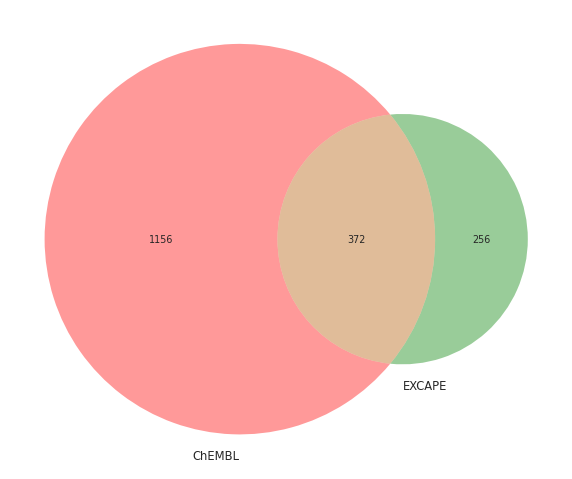

In [ ]:
# overlaps from SMILES strings
venn2([set(chembl.Molecule_ChEMBL_ID), 
       set(excape.Original_Entry_ID)], 
      set_labels = ['ChEMBL', 'EXCAPE'])

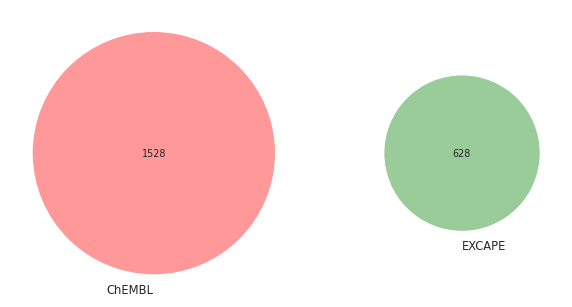

In [ ]:
# overlaps from SMILES strings
venn2([set(chembl.Smiles), set(excape.SMILES)], set_labels = ['ChEMBL', 'EXCAPE']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. One way to resolve this problem is to **STANDARDIZE the smiles strings.**

# **Curation step:** Standardize smiles strings, drop rows that are without base smiles

In [ ]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

1950
1528
1528


In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
0,CHEMBL3233676,NaN,0.0,622.85,2.0,6.84,22a,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,Inhibition,'=',13.75,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3240658,Reversible inhibition of human 5-HT3A expresse...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3232706,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,NaN,NaN,13.75,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...
1,CHEMBL773,GLYCINE,4.0,75.07,0.0,-0.97,glycine,NCC(=O)O,EC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN,NaN,NCC(=O)O
2,CHEMBL3261486,NaN,0.0,312.37,0.0,0.88,9,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,Activity,'=',83.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3268498,Partial agonist activity at human 5-HT3A recep...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3259590,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN,83.00,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2


In [ ]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
1638,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibition,'=',4.05,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507808,GPCRScan assay: inhibition of 5-HT3,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,Parental cells: HEKT | PMID: 2164935/8436978 |...,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507304,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,NaN,Compound concentration None 10.0 uM,4.05,


In [ ]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
1638,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibition,'=',4.05,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507808,GPCRScan assay: inhibition of 5-HT3,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,Parental cells: HEKT | PMID: 2164935/8436978 |...,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507304,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,NaN,Compound concentration None 10.0 uM,4.05,NaN


In [ ]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [ ]:
# Just checking
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles


## Standardize Excape-DB dataset
- What do you notice about the number of unique smiles strings before and after standardization?
- What does this mean for the nature of the compounds in a given dataset?
  - Hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [ ]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)

In [ ]:
excape = excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles


In [ ]:
excape.iloc[:, [-1, -2]].head(3)

,base_rdkit_smiles,SMILES
0,CN1C(=N)N(C)/C(=C/c2c[nH]c3ccccc23)C1=O,C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1
1,Cc1cccc2nc(N3CCN(C(C(=O)O)c4ccccc4)CC3)c3cccn3c12,N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...
2,Cc1cccc2nc(N3CCN(CC(O)=NO)CC3)c3cccn3c12,OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C


**Note the name `Smiles` compared to Excape**

In [ ]:
chembl[['base_rdkit_smiles','Smiles']].head(3)

,base_rdkit_smiles,Smiles
0,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...
1,NCC(=O)O,NCC(=O)O
2,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2


# **Curation step:** Save standardized datasets

**If want to save the files for later use, mount your google drive and create a folder and save it there.**

In [ ]:
chembl.to_csv("HTR3A_ChEMBL_SMILES_std.csv")
excape.to_csv("HTR3A_Excape_SMILES_std.csv")

## Examine compound overlaps from standardized smiles strings
- create venn diagram for the two datasets

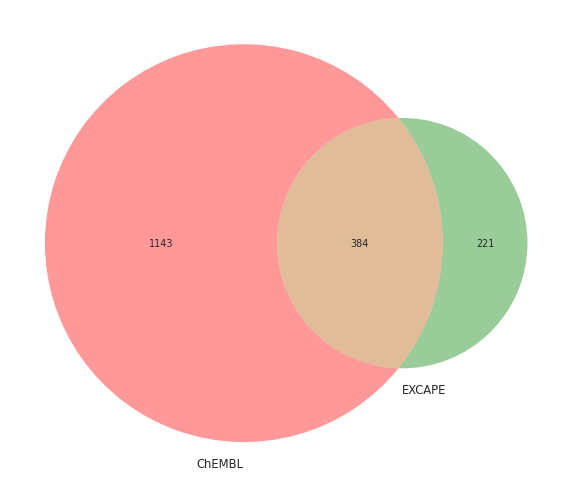

In [ ]:
mpv.venn2([set(chembl.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'EXCAPE']);

For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# **EDA: Examine compound diversity**

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage
ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists

In [ ]:
# ?plot_dataset_dist_distr   # to get help in a function

array([0.93548387, 0.86206897, 0.98076923, ..., 0.88235294, 0.84810127,
       0.9047619 ])

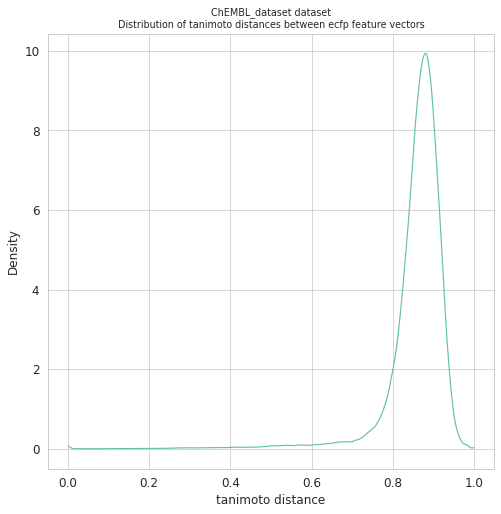

In [ ]:
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL_dataset')

In [ ]:
chembl[['Molecule_ChEMBL_ID','base_rdkit_smiles','pChEMBL_Value']].head(3)

,Molecule_ChEMBL_ID,base_rdkit_smiles,pChEMBL_Value
0,CHEMBL3233676,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,NaN
1,CHEMBL773,NCC(=O)O,NaN
2,CHEMBL3261486,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,NaN


Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


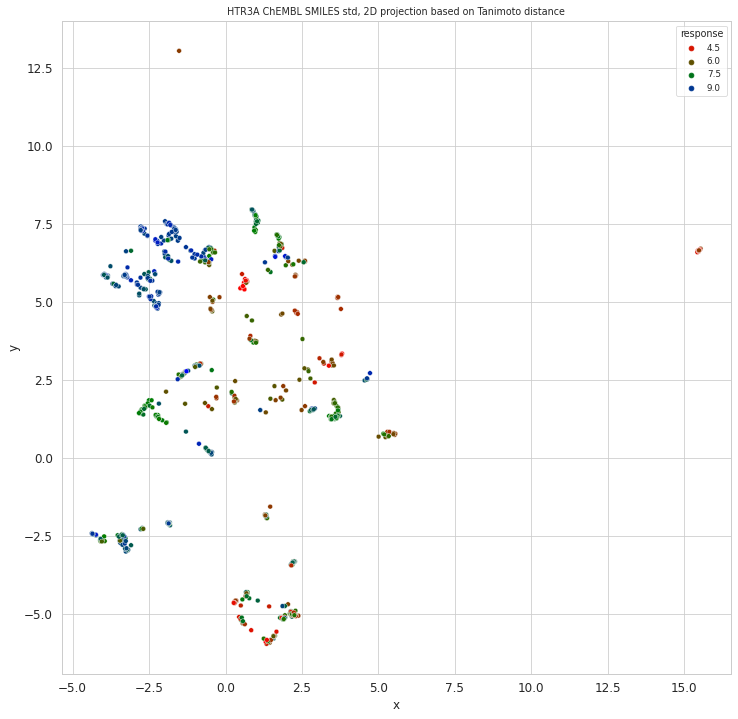

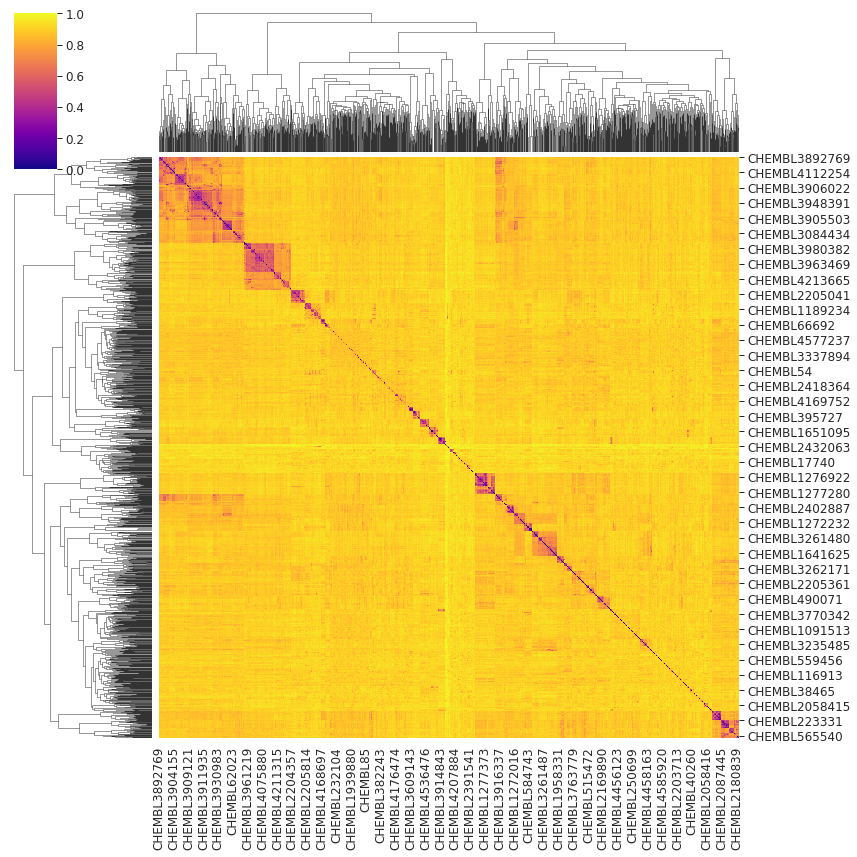

In [ ]:
dp.diversity_plots(dset_key='HTR3A_ChEMBL_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pChEMBL_Value')

## Create plots for Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

array([0.86842105, 0.90789474, 0.40983607, ..., 0.22058824, 0.77777778,
       0.77777778])

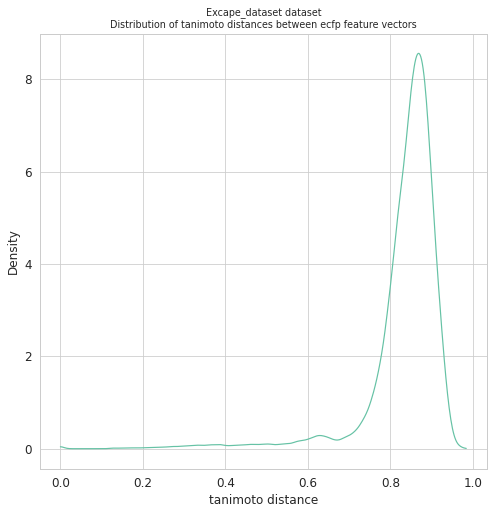

In [ ]:
plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape_dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


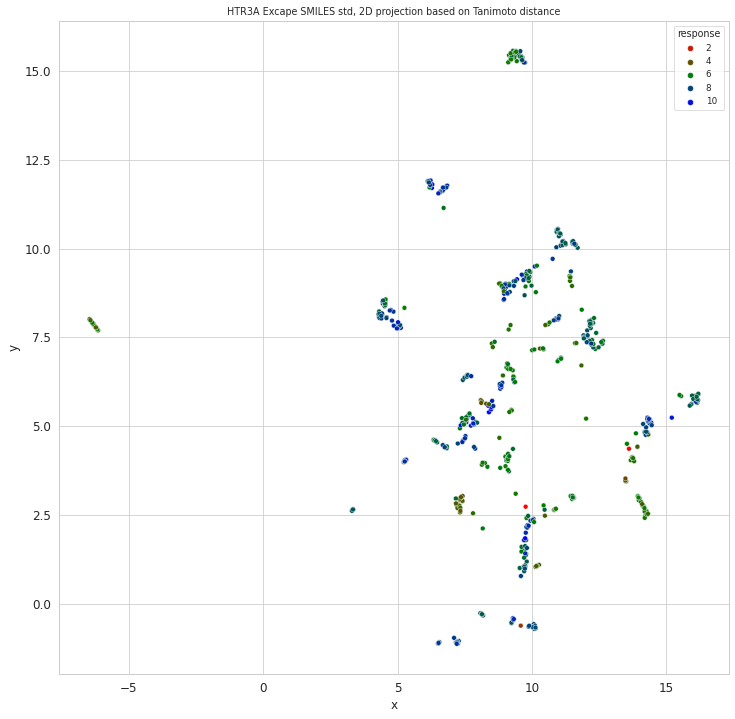

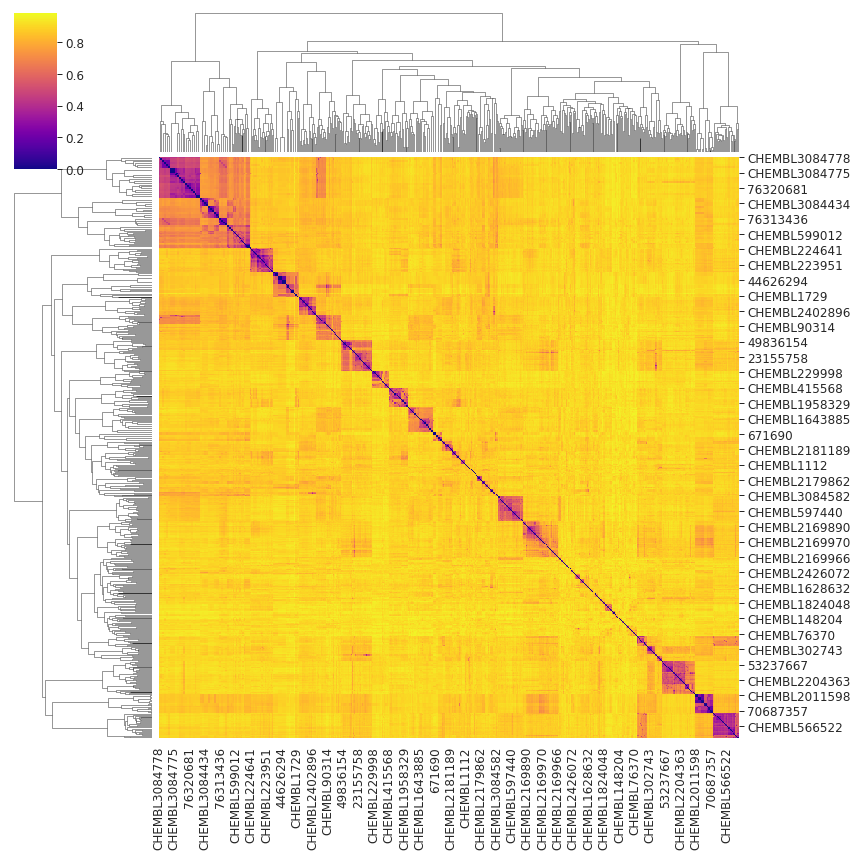

In [ ]:
dp.diversity_plots('HTR3A_Excape_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

## Discussion on the analysis of the heatmap and density plots
```
What are Morgan fingerprints (ecfp)? 
What does radius mean in the context of FPs?
What does a bit in an ECFP vector correspond to?
What radius and vector length are used in these functions?
Hint: look at the AMPL .py files for more info
```
Plesae check out, the GitHub repo for some rdkit code chunks for molecular fingerprint analysis, https://github.com/ravichas/ML-predict-drugclass

ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain scaffold or 'connectivity' between atoms in a molecule. The default values used in the AMPL diversity plots function for radius and length are 4 and 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.

```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well.  

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple), indicating that there are some compound groups that are very similar.


# **EDA: Curated data**

Data curation steps: 
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- Double check for no NA values left
- Save final curated dataset for further processing

In [ ]:
# chembl=pd.read_csv("HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("HTR3A_Excape_SMILES_std.csv", index_col=0)

In [ ]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)

In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles,pChEMBL_Value_nM
0,CHEMBL3233676,NaN,0.0,622.85,2.0,6.84,22a,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,Inhibition,'=',13.75,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3240658,Reversible inhibition of human 5-HT3A expresse...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3232706,1,Scientific Literature,Eur. J. Med. Chem.,2014.0,NaN,NaN,13.75,CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...,7.861697
1,CHEMBL773,GLYCINE,4.0,75.07,0.0,-0.97,glycine,NCC(=O)O,EC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL896288,Antagonist activity at human 5HT3A receptor ex...,F,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148788,1,Scientific Literature,J. Med. Chem.,2007.0,CHEMBL3307715,NaN,NaN,NCC(=O)O,NaN
2,CHEMBL3261486,NaN,0.0,312.37,0.0,0.88,9,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,Activity,'=',83.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3268498,Partial agonist activity at human 5-HT3A recep...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL1899,Serotonin 3a (5-HT3a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3259590,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN,83.00,O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2,7.080922


In [ ]:
chembl.Standard_Type.unique()

array(['Inhibition', 'EC50', 'Activity', 'IC50', 'Ki', 'Vmax',
       '% Inhibition of Control Specific Binding (Mean n=2)', 'Ka',
       'pIC50', 'Emax', 'Kd', 'pKi', 'Kb', 'Selectivity ratio',
       'Efficacy', '% Ctrl'], dtype=object)

In [ ]:
# select pIC50 values
vals = ['EC50', 'IC50', 'pIC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(1949, 48)
(602, 48)


In [ ]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(594, 48)


In [ ]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'"], dtype=object)

In [ ]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

,Standard_Relation,pRelation
3,'=',=
4,'>',<
5,'=',=
6,'>',<
7,'>',<


In [ ]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [ ]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(594, 49)
0 entries in input table are missing SMILES strings
517 unique SMILES strings are reduced to 517 unique base SMILES strings
(517, 5)


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL3911435,CN1C2COCC1CC(NC(=O)c1cn(-c3ncco3)c3ccccc13)C2,,8.988430,1
1,CHEMBL4082605,CN1C(Nc2nc3ccc(Cl)nc3s2)=NCC12CN1CCC2CC1,,4.886057,0
2,CHEMBL1277101,Cc1c(N2CCN(CCCCc3nc4c(c(=O)n3N)CCCC4)CC2)nc2cc...,<,7.000000,0
3,CHEMBL3896919,N#Cc1ccccc1-n1cc(C(=O)OC2CC3COCC(C2)N3)c2ccccc21,,8.956638,1
4,CHEMBL2180835,COc1ccc(-c2cc(NC(=O)CCCN3CCCCC3)[nH]n2)cc1,<,4.500000,0


In [ ]:
chembl_cur.to_csv("HTR3A_ChEMBL_cur.csv")

In [ ]:
# excape: has no relation col, so create one with all ''
# thresh = 7 in this case
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("HTR3A_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(649, 13)
['']
(645, 13)
0 entries in input table are missing SMILES strings
601 unique SMILES strings are reduced to 600 unique base SMILES strings
(600, 5)
['']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL159825,COc1cc(N)c(Cl)cc1C(=O)NC1CCN2CCC1C2,,8.25000,1
1,CHEMBL1643880,O=C(N[C@H]1CN2CCC1CC2)c1cnc2ccsc2c1O,,8.27000,1
2,CHEMBL1112,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1,,6.00000,0
3,56850927,O=C1CSC(=O)N1CCCCCCCCNCC1CCc2ccccc2O1,,7.92082,1
4,CHEMBL2180835,COc1ccc(-c2cc(NC(=O)CCCN3CCCCC3)n[nH]2)cc1,,4.50000,0


In [ ]:
chembl_cur['datasource'] = 'chembl'
excape_cur['datasource']='excape'
HTR3A = pd.concat([chembl_cur, excape_cur])
# HTR3A.to_csv("HTR3A_merge.csv")
print(HTR3A.shape)

(1117, 6)


In [ ]:
import importlib
importlib.reload(curate_data)
HTR3A_cur = curate_data.aggregate_assay_data(HTR3A, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HTR3A_cur.shape)
print(HTR3A.relation.unique())
HTR3A_cur.head()

0 entries in input table are missing SMILES strings
1004 unique SMILES strings are reduced to 1004 unique base SMILES strings
(1004, 5)
['' '<' '>']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL3911435,CN1C2COCC1CC(NC(=O)c1cn(-c3ncco3)c3ccccc13)C2,,8.988430,1
1,CHEMBL159825,COc1cc(N)c(Cl)cc1C(=O)NC1CCN2CCC1C2,,8.250000,1
2,CHEMBL4082605,CN1C(Nc2nc3ccc(Cl)nc3s2)=NCC12CN1CCC2CC1,,4.886057,0
3,CHEMBL1277101,Cc1c(N2CCN(CCCCc3nc4c(c(=O)n3N)CCCC4)CC2)nc2cc...,<,7.000000,0
4,CHEMBL1643880,O=C(N[C@H]1CN2CCC1CC2)c1cnc2ccsc2c1O,,8.270000,1


In [ ]:
HTR3A_cur.relation.unique()

array(['', '<'], dtype=object)

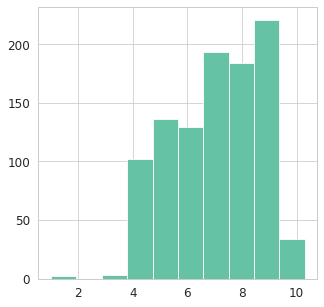

In [ ]:
HTR3A_cur.pXC50.hist(figsize=(5,5));

In [ ]:
HTR3A_cur.active.sum()

555

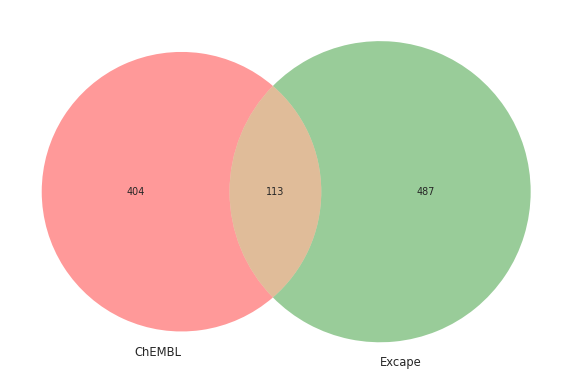

In [ ]:
mpv.venn2([set(HTR3A.loc[HTR3A.datasource=='chembl','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','Excape']);

In [ ]:
HTR3A.datasource

0      chembl
1      chembl
2      chembl
3      chembl
4      chembl
        ...  
595    excape
596    excape
597    excape
598    excape
599    excape
Name: datasource, Length: 1117, dtype: object

In [ ]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s

2021-06-10 14:57:05,039 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


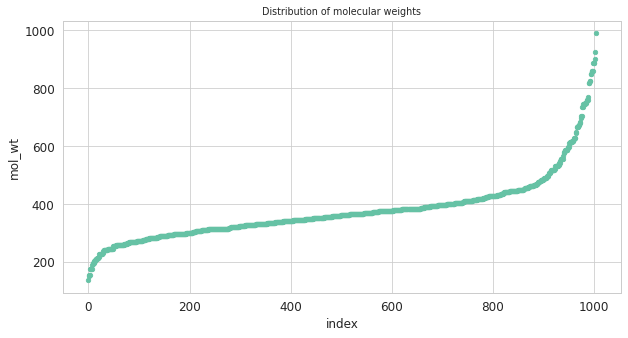

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

(1004, 7)
(1004, 7)


2021-06-10 14:57:05,251 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


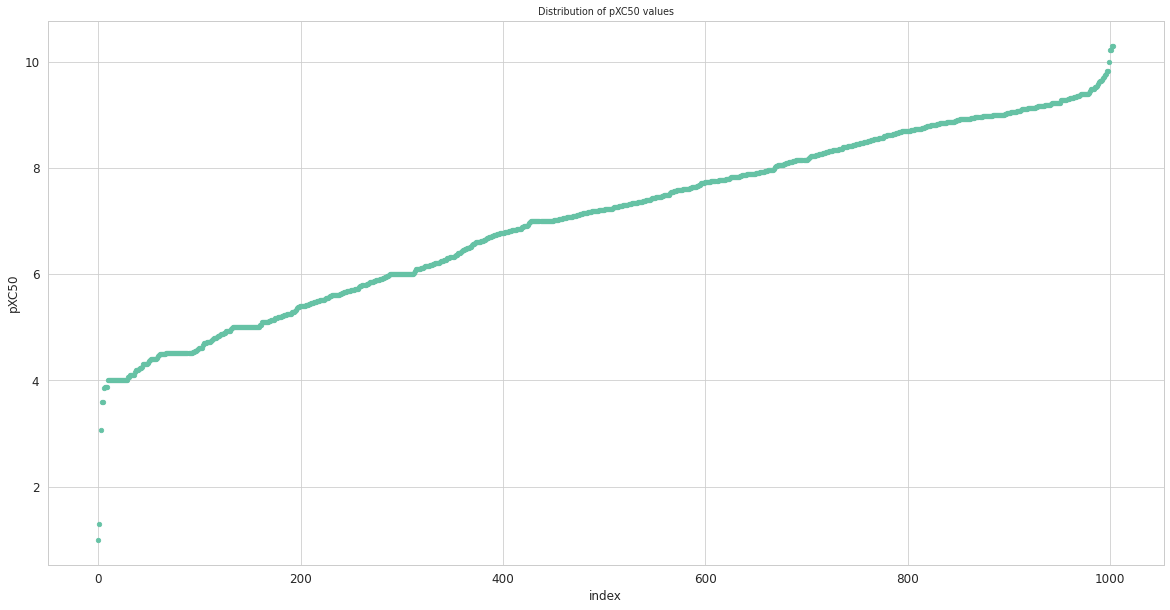

In [ ]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

(1004, 7)
(1002, 7)


In [ ]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


array([0.94444444, 0.88888889, 0.94642857, ..., 0.83950617, 0.83950617,
       0.85294118])

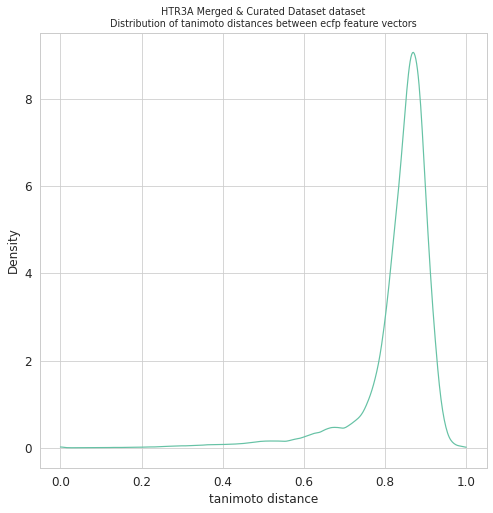

In [ ]:
plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [ ]:
cur_fname = "HTR3A_cur.csv"
HTR3A_cur.to_csv(cur_fname)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


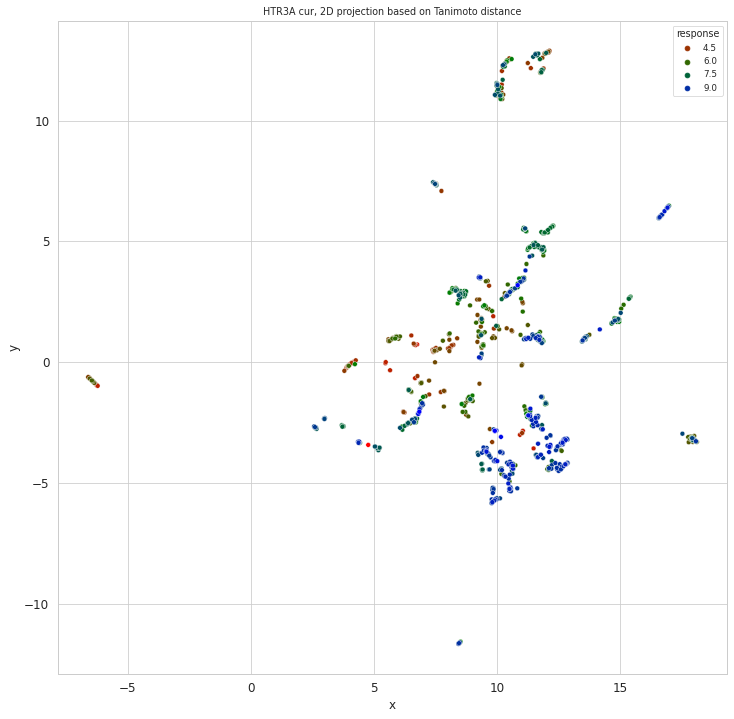

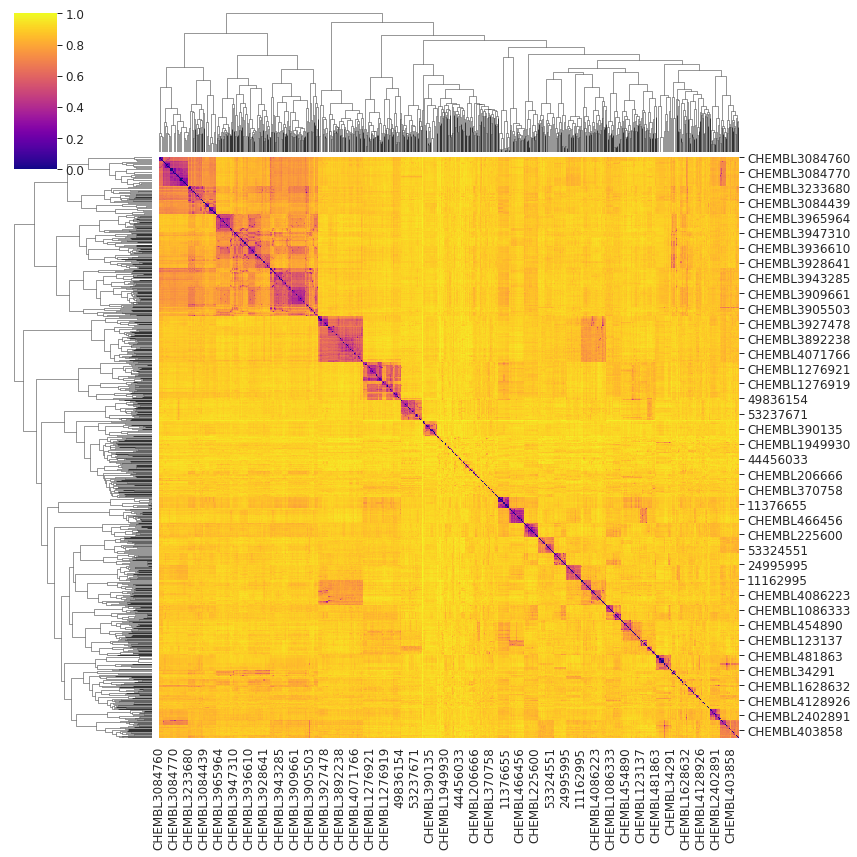

In [ ]:
dp.diversity_plots(cur_fname, 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

In [ ]:
## Things to explore
# dp.diversity_plots(cur_fname, 
#                    datastore = False,
#                    id_col ='compound_id', 
#                    smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, 
#                    response_col = 'pXC50',
#                    ecfp_radius = 2)

In [ ]:
## Things to explore
# dp.diversity_plots(cur_fname, 
#                    datastore = False,
#                    id_col ='compound_id', 
#                    smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, 
#                    response_col = 'pXC50',
#                    ecfp_radius = 6)

The following code takes too long. Try only when you are running this
on a dedicated system/server

In [ ]:
# warning: 1000 doesn't work, takes too long
importlib.reload(dp)
# dp.diversity_plots(cur_fname, 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

<module 'atomsci.ddm.pipeline.diversity_plots' from '/opt/conda/envs/atomsci/lib/python3.6/site-packages/atomsci/ddm/pipeline/diversity_plots.py'>

#**Featurization**


- Featurize with structure-based fingerprints like ECFP
- Molecular descriptor sets like RDKit and Mordred
  - these are high - dimensional datasets (200-2000 features or 'dimensions')
  - so UMAP, tSNE and other dimensionality reduction techniques will help and visualize the 'chemical space' of the dataset

In [ ]:
# import deepchem as dc

In [ ]:
## Calculate descriptors 
from atomsci.ddm.pipeline import featurization as feat
ecfp_featurizer = dc.feat.CircularFingerprint(radius = 2, size = 1024)

## use featurizer to featurize the SMILES
HTR3A_ecfp_arr, HTR3A_valid = feat.featurize_smiles(df=HTR3A_cur, 
                                                    featurizer=ecfp_featurizer, 
                                                    smiles_col="base_rdkit_smiles")

In [ ]:
# HTR3A_cur['base_rdkit_smiles']
# HTR3A_cur.head()

### Please check this Jupyter notebook for Fingerprint analysis,
https://github.com/ravichas/ML-predict-drugclass/blob/master/predict_drugclass_COLAB.ipynb

In [ ]:
#@title
print(HTR3A_ecfp_arr.shape)
print(HTR3A_valid.shape)
print(HTR3A.shape)

(1002, 1024)
(1002,)
(1117, 6)


In [ ]:
np.unique(HTR3A_valid, return_counts=True)

(array([ True]), array([1002]))

In [ ]:
# SHOW FPs

**Mordred: For computing descriptors**

We will be using a python package called mordred for generating chemical descriptors. 

* Mordred publication, https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y
* Mordred Github Page: https://github.com/mordred-descriptor/mordred 
* Click the following link to see the complete list of mordred descriptors, https://mordred-descriptor.github.io/documentation/master/descriptors.html


In [ ]:
# Things to run if you run into mordred function related error
# iml.reload(feat)
# feat.mordred_supported

In [ ]:
mols = [Chem.MolFromSmiles(smi)   for smi in HTR3A_cur.base_rdkit_smiles]
HTR3A_mordred_descrs = feat.compute_2d_mordred_descrs(mols[:10])

# calculate Mordred descriptors
HTR3A_mordred_df, HTR3A_mordred_valid = feat.compute_mordred_descriptors_from_smiles(HTR3A_cur.base_rdkit_smiles.values[:10], 
                                                                                     smiles_col="rdkit_smiles")

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [ ]:
HTR3A_mordred_descrs

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,ATS0d,...,NsOH,NdO,NssO,NaaO,NsF,NdS,NssS,NaaS,NddssS,NsCl,NsBr,SsCH3,SdCH2,SssCH2,SdsCH,SaaCH,SsssCH,StsC,SdssC,SaasC,SaaaC,SssssC,SsNH2,SssNH,SaaNH,StN,SdsN,SaaN,SsssN,SddsN,SaasN,SsOH,SdO,SssO,SaaO,SsF,SdS,SssS,SaaS,SddssS,SsCl,SsBr,MDEC-22,MDEC-23,MDEC-33
0,17.613368,13.642878,0.0,1.0,29.931137,2.525285,5.050569,29.931137,1.360506,4.052115,4.146042,0.188456,2.210612,162.429235,7.383147,5.878700,12.0,12.0,43.0,22.0,0.0,0.0,3.0,21.0,0.0,19.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,269.0,385.0,421.0,360.0,353.0,320.0,228.0,106.0,143.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.973380,0.000000,14.220372,1.419258,0.000000,0.000000,3.543067,0.000000,0.000000,0.0,3.486800,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,20.190455,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.411646,26.804452,12.450393
1,8.900428,7.943301,0.0,0.0,13.114788,2.497212,4.994424,13.114788,1.192253,3.373660,3.159997,0.287272,1.245881,38.478828,3.498075,3.745418,0.0,0.0,29.0,11.0,0.0,2.0,1.0,18.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,108.0,139.0,84.0,13.0,0.0,0.0,0.0,0.0,82.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.756551,0.000000,5.314676,0.000000,0.000000,0.823449,0.000000,0.000000,0.000000,0.000000,0.378472,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,6.060185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.301927,2.828427,NaN
2,17.068022,13.635070,0.0,1.0,29.224157,2.413125,4.635935,29.224157,1.328371,4.018469,3.737865,0.169903,2.106972,248.616405,11.300746,6.304369,6.0,6.0,46.0,22.0,0.0,0.0,3.0,24.0,0.0,19.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,244.0,320.0,287.0,258.0,247.0,239.0,201.0,144.0,136.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.891743,0.000000,7.946668,0.000000,9.994445,0.181176,6.486113,0.261977,1.016509,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,4.289151,0.0,0.000000,0.000000,12.432218,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.100902,14.578906,2.318984
3,7.607685,7.725288,0.0,0.0,11.828972,2.175328,4.350655,11.828972,1.075361,3.236499,2.886164,0.262379,1.155238,43.964739,3.996794,3.878698,0.0,0.0,29.0,11.0,0.0,0.0,1.0,18.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,80.0,78.0,58.0,51.0,50.0,26.0,4.0,0.0,64.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.892938,3.559433,1.669676,3.712106,0.000000,0.000000,0.000000,1.296169,0.000000,0.000000,-0.702431,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,9.488775,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.147345,1.709148,NaN
4,24.590741,18.998356,0.0,2.0,38.168183,2.619348,5.012869,38.168183,1.272273,4.372052,4.649836,0.154995,2.635444,277.515086,9.250503,6.724488,18.0,20.0,64.0,30.0,0.0,0.0,4.0,34.0,0.0,26.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,304.0,370.0,552.0,559.0,562.0,496.0,430.0,329.0,229.0,210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.735123,0.000000,4.000240,0.000000,17.964267,0.000000,0.000000,0.000000,5.979602,5.597066,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,5.181944,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.388513,28.229165,10.591274
5,27.101331,20.963325,0.0,2.0,43.577098,2.620733,5.018627,43.577098,1.281679,4.481471,4.738395,0.139365,2.779474,495.559098,14.575268,7.429462,18.0,20.0,72.0,34.0,0.0,0.0,4.0,38.0,0.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,402.0,592.0,607.0,618.0,588.0,572.0,485.0,369.0,230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.212451,8.002643,5.748905,4.078985,17.932323,0.000000,0.000000,0.000000,5.872790,5.501000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,5.174189,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.921677,32.753532,10.591274
6,46.818184,30.294265,0.0,

# **Helpful links:** 


1.   https://github.com/ATOMScience-org/AMPL/tree/Tutorials/atomsci/ddm/examples/tutorials
2.   https://github.com/ravichas/ML-predict-drugclass


In [ ]:
!date

Thu Jun 10 14:57:44 UTC 2021
